# Category Clusterer Model
Use a clustering model to reduce the amount of categories

## Imports

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score


# import helpers module
import helpers
import importlib
importlib.reload(helpers)

SEP = 100 * '-'


## Load dataset

In [202]:
# load dataset
data = helpers.load_pickled_dataset('pickle/data_processed.pkl')

helpers.print_random_product_sheet(data)

Dataset loaded from pickle/data_processed.pkl.
----------------------------------------------------------------------------------------------------
[name] AmazonBasics AAA Performance Alkaline Batteries (36 Count)
----------------------------------------------------------------------------------------------------
[brand] Amazonbasics
----------------------------------------------------------------------------------------------------
[categories] AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care
----------------------------------------------------------------------------------------------------
[reviews.rating] 5.0
----------------------------------------------------------------------------------------------------
[review] Love the Echo, so easy to use and set up.
Great gift for t

## Review Categories

In [203]:
# print unique categories
unique_categories = data['categories'].unique()
print(f'There are {len(unique_categories)} unique categories')

# print(SEP)
# for idx, cat in enumerate(unique_categories):
#     print(f"[{idx}] {cat}")

There are 99 unique categories


Fire Tablets,Tablets,Computers & Tablets,All Table: 10966
AA,AAA,Health,Electronics,Health & Household,Camco: 7754
Stereos,Remote Controls,Amazon Echo,Audio Docks & : 5948
Electronics,iPad & Tablets,All Tablets,Fire Tablet: 3611
AA,AAA,Electronics Features,Health,Electronics,Hea: 3519
Walmart for Business,Office Electronics,Tablets,Of: 3176
Fire Tablets,Tablets,All Tablets,Amazon Tablets,Co: 2478
Fire Tablets,Tablets,All Tablets,Amazon Tablets,Ge: 2442
Fire Tablets,Computers/Tablets & Networking,Electr: 2369
Tablets,Fire Tablets,Computers & Tablets,All Table: 1752
Fire Tablets,Learning Toys,Toys,Tablets,Amazon Tab: 1676
Computers,Fire Tablets,Electronics Features,Comput: 1503
Computers/Tablets & Networking,Tablets & eBook Rea: 1456
Fire Tablets,Computers/Tablets & Networking,Tablet: 1033
Fire Tablets,Computers/Tablets & Networking,Tablet: 987
Fire Tablets,Android Tablets,Tablets,All Tablets,A: 745
Computers,Amazon Echo,Virtual Assistant Speakers,A: 650
Amazon Echo,Home Theater & Audio,

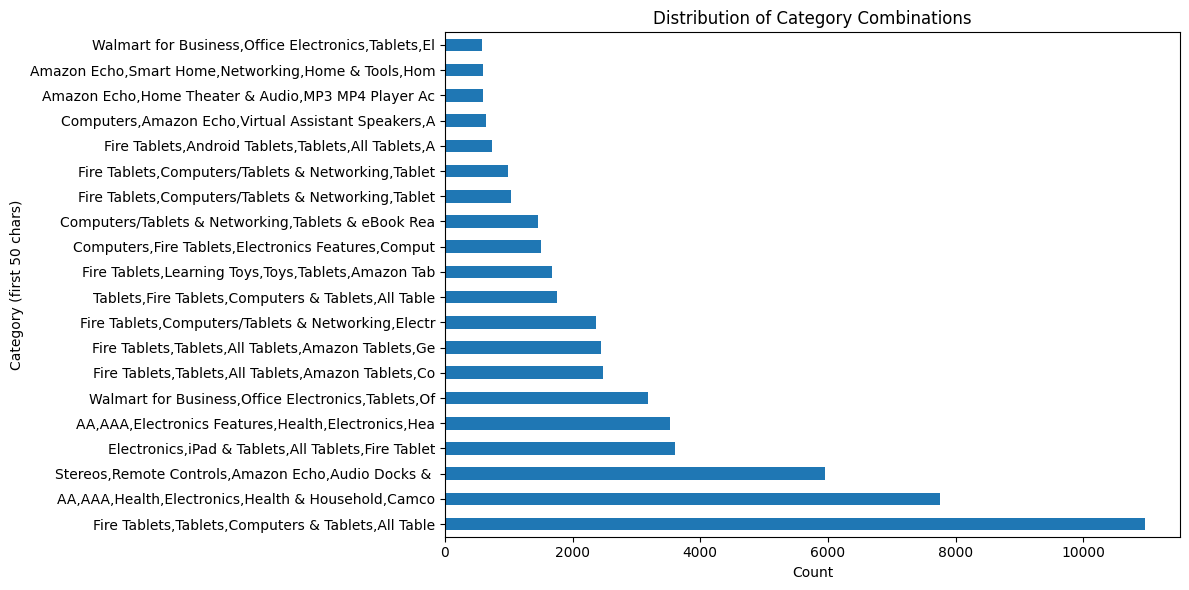

In [204]:
# Check categories balance, how many reviews are there per category
category_counts = data['categories'].value_counts()

for category, count in category_counts.items():
    print(f"{category[:50]}: {count}")

# Plot the distribution with inverted axes
plt.figure(figsize=(12, 6))
cat_filter = 20
bars = category_counts[:cat_filter].plot(kind='barh')
plt.title('Distribution of Category Combinations')
plt.ylabel('Category (first 50 chars)')
plt.xlabel('Count')

# Update the y-axis labels to show only the first 50 characters
bars.set_yticklabels([cat[:50] for cat in category_counts.index[:cat_filter]])

plt.tight_layout()
plt.show()


The amount of reviews per category is highly unbalanced. We need to group them as best as possible to balanced sub categories

## Model choice

We can opt for a Feature Extraction or Sentence Similarity model. 

Given the complex and hierarchical nature of our categories, Feature Extraction is recommended for generating embeddings that capture the structure and relationships within each category string. Unlike Sentence Similarity, which focuses on general semantic content, Feature Extraction is better suited for the nuanced clustering of multi-level categories. 

To implement this, we can use an existing transformer model for embeddings, then apply a clustering algorithm (such as KMeans) to group the categories into 4 or 5 clusters.

## Create Embeddings for my categories

Let's try a simple embedding model like [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) to generate embeddings from our classes.

This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [205]:
# initialise model
embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# create corpus
corpus = data['categories'].unique().tolist()
print(len(corpus), 'unique categories')

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512_vnni.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

openvino/openvino_model.xml:   0%|          | 0.00/211k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

99 unique categories


In [206]:
# create embeddings for each corpus category
corpus_embeddings = embedder.encode(corpus)
print(len(corpus_embeddings), 'embeddings created')
print("Embeddings shape:", corpus_embeddings[0].shape)

99 embeddings created
Embeddings shape: (384,)


## Research KMeans hyperparameters
Let's try different parameters and check the elbow method and silhouette score to determine how many main categories to group them into

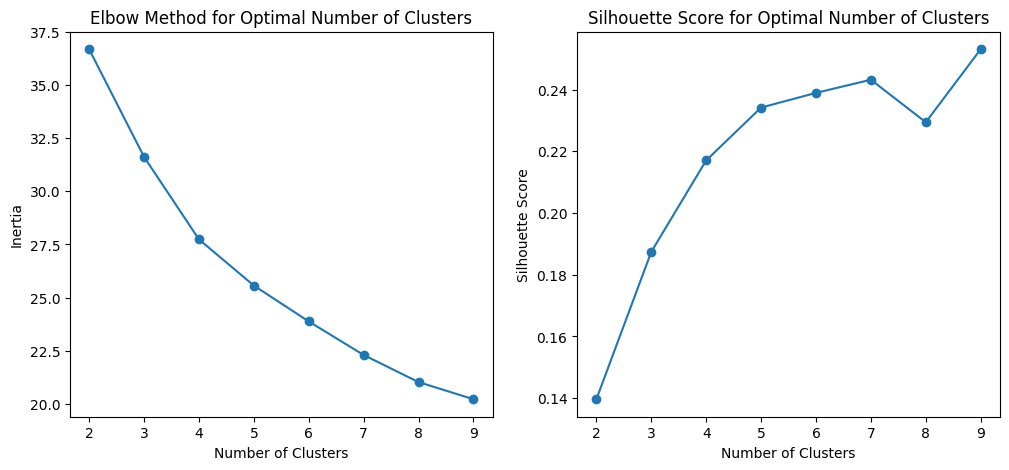

In [207]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Number of clusters to test
range_n_clusters = list(range(2, 10))  # Try from 2 to 10 clusters

# Store inertia and silhouette scores for each number of clusters
inertia_scores = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=20,
        max_iter=300,
        algorithm="lloyd",
        random_state=0
    )
    cluster_labels = kmeans.fit_predict(corpus_embeddings)
    
    # Store the inertia (for elbow method)
    inertia_scores.append(kmeans.inertia_)
    
    # Calculate silhouette score for each clustering result
    silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the inertia and silhouette scores to determine the best number of clusters
plt.figure(figsize=(12, 5))

# Elbow Method (Inertia)
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Number of Clusters")

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Number of Clusters")

plt.show()


The inertia plot doesn’t show a very clear "elbow," but the rate of decrease starts to slow significantly after about 4 clusters. This suggests that 4 might be an efficient choice for the number of clusters, as adding more clusters beyond this point yields diminishing returns in reducing inertia.

The silhouette score increases up to 6 clusters and then remains relatively stable, peaking again at 9 clusters. A higher silhouette score suggests better-defined clusters. Based on this, we might consider using 6 clusters to balance between stability and interpretability.

## Unsupervised clustering using KMeans
Let's try 4, 5 and 6 clusters

In [208]:
# Fit KMeans clustering model
num_clusters = 6

clustering_model = KMeans(
    n_clusters=num_clusters,
    init="k-means++",
    n_init=20,
    max_iter=300,
    algorithm="auto",
    random_state=42
)

clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

# Organize clustered categories
clustered_categories = [[] for _ in range(num_clusters)]
for category_id, cluster_id in enumerate(cluster_assignment):
    clustered_categories[cluster_id].append(corpus[category_id])

# Dictionary to store the most common words for each cluster
cluster_words = {}

# ignore some recurrent words
ignored_words = ['Amazon']

# Process each cluster
for i, cluster in enumerate(clustered_categories):

    # Clean and prepare the cluster text
    clean_cluster = re.sub(r'[^A-Za-z0-9\s]', '', " ".join(cluster))
    all_words = [word.strip() for word in clean_cluster.split()]

    # Count frequency of each word and get top 10
    word_counts = Counter(all_words)
    for word in ignored_words:
        if word in word_counts:
            del word_counts[word]
    most_common_words = word_counts.most_common(10)

    # Store the results in the dictionary
    cluster_words[f"Cluster {i}"] = most_common_words

    # Print results for inspection
    print(f"CLUSTER {i}:")
    for word, count in most_common_words:
        print(f"{word} ({count})")
    print(SEP)



/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


CLUSTER 0:
eBook (14)
Book (13)
Device (13)
Adapters (13)
AccessoriesKindle (11)
AccessoriesAmazon (10)
Kindle (10)
Generation (9)
ReaderComputers (8)
Readers (8)
----------------------------------------------------------------------------------------------------
CLUSTER 1:
Fire (19)
TabletsAmazon (12)
Tablets (12)
TabletsComputers (11)
TabletsComputersTablets (11)
eBook (11)
TabletsAll (9)
TabletsTabletsAll (8)
Readers (8)
TabletsTablets (5)
----------------------------------------------------------------------------------------------------
CLUSTER 2:
Home (26)
Smart (14)
Audio (14)
Device (14)
Speakers (14)
Assistant (11)
Hubs (9)
Wireless (8)
Player (7)
Hub (7)
----------------------------------------------------------------------------------------------------
CLUSTER 3:
Cases (7)
Dining (5)
Storage (5)
Accessories (5)
Computer (4)
AccessoriesLaptop (4)
Video (4)
Device (4)
File (4)
Drive (4)
-------------------------------------------------------------------------------------------

I get the best results will less clustering errors running KMenas with 6 clusters.

## Plot clustering results

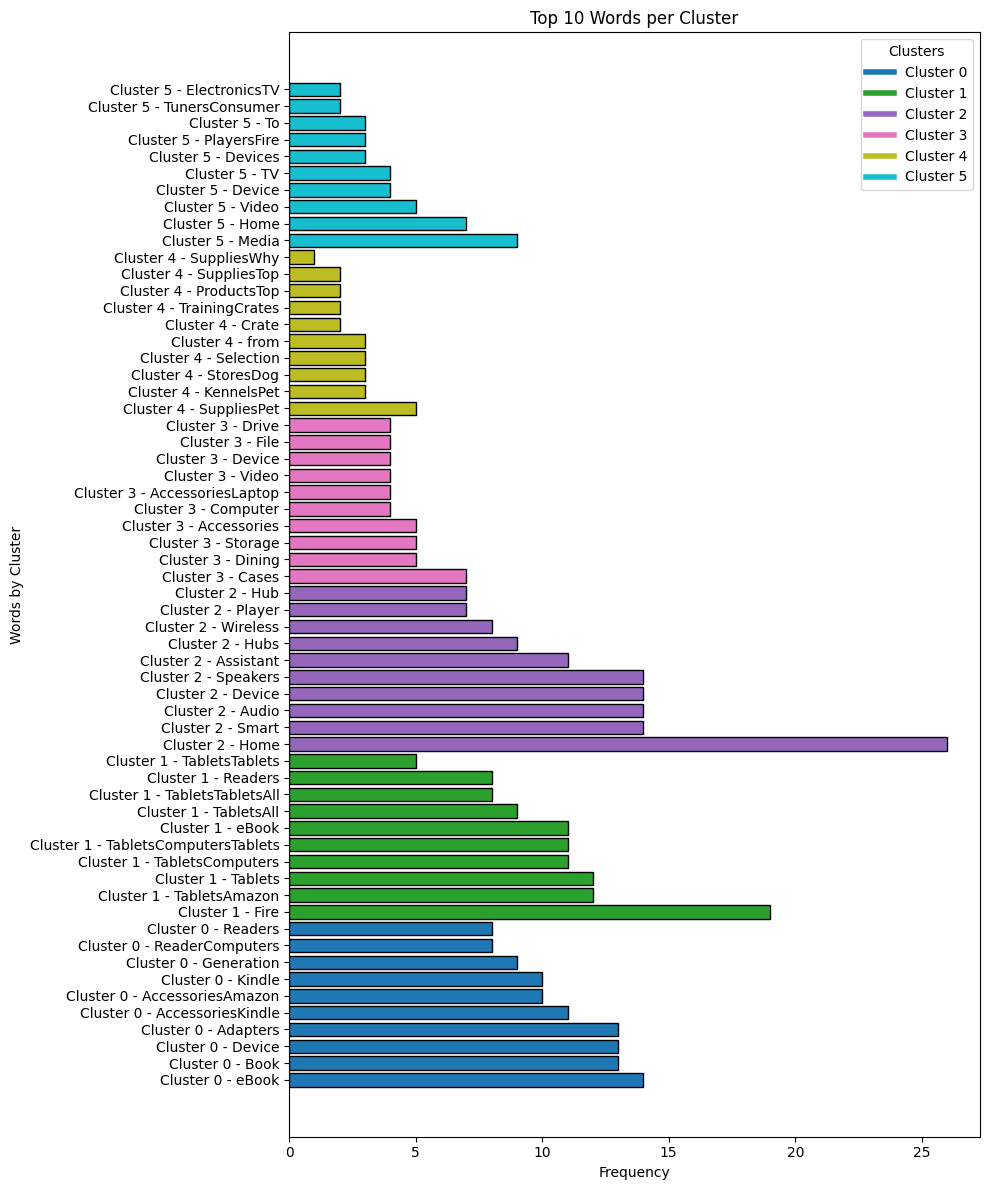

In [209]:
# Generate distinct colors for each cluster
colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_words)))

# Prepare data for plotting
words = []
counts = []
color_map = []
cluster_labels = []

for idx, (cluster, word_count_list) in enumerate(cluster_words.items()):
    for word, count in word_count_list:
        words.append(f"{cluster} - {word}")
        counts.append(count)
        color_map.append(colors[idx])
        cluster_labels.append(cluster)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(words, counts, color=color_map, edgecolor="black")

# Legend
legend_labels = [f"Cluster {i}" for i in range(len(cluster_words))]
unique_colors = [colors[i] for i in range(len(cluster_words))]
custom_legend = [plt.Line2D([0], [0], color=unique_colors[i], lw=4) for i in range(len(unique_colors))]
plt.legend(custom_legend, legend_labels, title="Clusters", loc="upper right")

# Labels and title
plt.ylabel("Words by Cluster")
plt.xlabel("Frequency")
plt.title("Top 10 Words per Cluster")

plt.tight_layout()
plt.show()

In [210]:
# Calculate silhouette score
silhouette_avg = silhouette_score(corpus_embeddings, clustering_model.labels_)
print(f'Silhouette Score: {silhouette_avg:.4f}')


Silhouette Score: 0.2389


A silhouette score of 0.2389 indicates that the clusters are somewhat loosely defined, meaning there may be overlapping clusters or that some data points are not well-separated from others.

## Let's rename our clusters and add them to the dataset

In [211]:
# manually assigning names to each cluster
cluster_names = {
    0: "Electronics & Media",
    1: "Tablets & eReaders",
    2: "Accessories & Adapters",
    3: "Home & Smart Devices",
    4: "Pet Supplies",
    5: "Video & Streaming"
}

# clustering the corpus: each category receives a cluster name
clustered_corpus = {}
for i, cat in enumerate(corpus):
    clustered_corpus[cat] = cluster_names[cluster_assignment[i]]

# update dataset with a new column
data_clustered = data.copy()
data_clustered['clusterCategories'] = data_clustered['categories'].map(clustered_corpus)

# drop othe categories column
data_clustered.drop('categories', axis=1, inplace=True)

print(data_clustered.info())
data_clustered.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59079 entries, 0 to 59078
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               59079 non-null  object 
 1   brand              59079 non-null  object 
 2   reviews.rating     59047 non-null  float64
 3   review             50174 non-null  object 
 4   clusterCategories  59079 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.3+ MB
None


,name,brand,reviews.rating,review,clusterCategories
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Great device for reading. Definately pricey.\n...,Electronics & Media
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,"Excellent Kindle\nThe best Kindle ever, for me...",Electronics & Media
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,Love it\nI absolutely love this reader. The bi...,Electronics & Media
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Good kindle\nI always use it when i read ebook...,Electronics & Media
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,"So much to love, but slippery\nLove bigger scr...",Electronics & Media
5,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,Expensive but nice\nI was used to the Kindle 3...,Electronics & Media
6,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,4.0,Like it\nI love this so far only downside is y...,Electronics & Media
7,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Love it!\nI adore this kindle. I have owned vo...,Electronics & Media
8,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,"You get what you pay for\nBest reader, super l...",Electronics & Media
9,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,5.0,Best Kindle ever....\nThis is the best Kindle ...,Electronics & Media


In [212]:
helpers.print_random_product_sheet(data_clustered)

----------------------------------------------------------------------------------------------------
[name] Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case
----------------------------------------------------------------------------------------------------
[brand] Amazon
----------------------------------------------------------------------------------------------------
[reviews.rating] 5.0
----------------------------------------------------------------------------------------------------
[review] Amazon batteries ROCK!!!
What else can you say Amazon ROCKS and so do their batteries!!!
----------------------------------------------------------------------------------------------------
[clusterCategories] Home & Smart Devices


## Pickle categorized dataset

In [213]:
data_clustered.to_pickle('pickle/data_clustered.pkl')